<a href="https://colab.research.google.com/github/SEIGO55/ADS_deepL/blob/main/4_transfer_learning_vgg16_own_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

目的
* **転移学習**で空き缶とビンとペットボトルとたばこの吸い殻を高精度で分類する。

準備
* GPUを用いて処理を行うために、上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base_path = '/content/drive/MyDrive/Deep learning/'

## 枚数確認

In [7]:
import os

# サブフォルダー
sub_folders = ['can', 'bin', 'petbottle', 'tabacco']

# 各サブフォルダー内の画像ファイル数を数える
t0 = t1 = t2 = t3 = 0

for index, folder in enumerate(sub_folders):
    full_path = os.path.join('/content/drive/MyDrive/Deep learning/project2/train/', folder)
    count = len([file for file in os.listdir(full_path) if file.endswith(('.jpg', '.jpeg', '.png'))])

    if folder == 'can':
        t0 = count
    elif folder == 'bin':
        t1 = count
    elif folder == 'petbottle':
        t2 = count
    elif folder == 'tabacco':
        t3 = count

ttl_train = t0 + t1 + t2 + t3

# 各変数に格納されたファイル数を出力
print("train:","can:", t0, "bin:", t1, "petbottle:", t2, "tabacco:", t3, "total", t0+t1+t2+t3)

# 各サブフォルダー内の画像ファイル数を数える
v0 = v1 = v2 = v3 = 0

for index, folder in enumerate(sub_folders):
    full_path = os.path.join('/content/drive/MyDrive/Deep learning/project2/validation/', folder)
    count = len([file for file in os.listdir(full_path) if file.endswith(('.jpg', '.jpeg', 'JPG','.png'))])

    if folder == 'can':
        v0 = count
    elif folder == 'bin':
        v1 = count
    elif folder == 'petbottle':
        v2 = count
    elif folder == 'tabacco':
        v3 = count

ttl_validation = v0 + v1 + v2 + v3

# 各変数に格納されたファイル数を出力
print("validation:","can:", v0, "bin:", v1, "petbottle:", v2, "tabacco:", v3, "total", v0+v1+v2+v3)

train: can: 90 bin: 90 petbottle: 90 tabacco: 90 total 360
validation: can: 30 bin: 30 petbottle: 30 tabacco: 30 total 120


VGG16を利用した転移学習のためのプログラムを作成

プログラムの構造
* 訓練データを**FC層を取り除いた**VGG16モデルに入力し、出力結果をバリナリデータとして保存
* これを再度読み込んで、**自前のFC層を備えたネットワーク**で学習
* 最終的に1個のニューロンに出力
* テストデータについても同じ処理

if not os.path.exists
* outputというディレクトリの存在チェックを行いなければ作成

if not os.path.exists('output'):

    os.mkdir('output')

* Pythonで新しいディレクトリ（フォルダ）を作成するには標準ライブラリosモジュールのos.mkdir()を使います。

VGG16: https://keras.io/ja/applications/
* ImageNetで学習した重みをもつ画像分類のモデル

.flow_from_directory: https://keras.io/ja/preprocessing/image/
* ディレクトリへのパスを受け取り、拡張/正規化したデータのバッチを生成します。

.predict_generator: https://keras.io/ja/models/sequential/

* ジェネレータから生成されたデータに対して予測します。

npyファイル: https://note.nkmk.me/python-numpy-load-save-savez-npy-npz/
* NumPy配列ndarrayをNumPy独自フォーマットのバイナリファイル（npy, npz）で保存する場合、データ型dtypeや形状shapeなどの情報がそのまま保存される。

npyファイル: https://qiita.com/ShozF/items/ef3629064f930e85c20f
* ヘッダ部の情報に基づいて、配列要素がバイト列として隙間なく格納されています。

os.path.join()
* 引数に渡した2つの文字列を結合し、1つのパスにすることが出来ます。

In [8]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
import numpy as np
import os

#Google DriveのMyDrive直下に  "Deep learning", "project", "3data", "train"フォルダを作成 Directoryのpathの設定
#Google DriveのMyDrive直下に  "Deep learning", "project", "3data", "validation"フォルダを作成  DirectoryのPathの設定
train_data_dir = '/content/drive/MyDrive/Deep learning/project2/train' # 訓練データのフォルダ
validation_data_dir = '/content/drive/MyDrive/Deep learning/project2/validation' # テストデータのフォルダ
result_dir = '/content/drive/MyDrive/Deep learning/project2/results'        # VGG16の出力結果を保存するフォルダ

# resultsフォルダが存在しなければ作成
if not os.path.exists(result_dir):
    os.mkdir(result_dir)


 ## コードの解説

このコードは、画像認識において深層学習モデルの一つであるVGG16を使用して、指定された画像データセット（ここでは 'can', 'bin', 'petbottle', 'tobacco' などが含まれる）に対して特徴抽出を行い、その結果を保存するための関数 save_VGG16_outputs を定義しています。詳細に解説します：

VGG16モデルの設定:

VGG16 関数を使用して、VGG16モデルを読み込みます。ここでは、トップレイヤー（全結合層）は含めず、ImageNetで学習した重みを使用します。これにより、一般的な画像特徴を識別できるようになります。
データ生成:

ImageDataGenerator を用いて、画像データの前処理（ここではスケーリングのみ）を行います。
flow_from_directory メソッドを使って、指定したディレクトリ（訓練データとテストデータ）から画像データを読み込みます。画像はリサイズされ、バッチサイズに従って処理されます。
モデルによる特徴抽出:

model.predict_generator を使用して、訓練データとテストデータをモデルに通し、特徴を抽出します。この出力はVGG16モデルの最終層の出力であり、画像の深層特徴を表しています。
出力の保存:

得られた特徴データ（VGG16モデルの出力）をNumPy配列として .npy ファイルに保存します。これにより、後の分析や学習のためにデータを容易に再利用できます。
このプロセスは、深層学習における「転移学習」の一形態です。VGG16モデルは一般的な画像特徴を学習しており、このモデルを使って新しいデータセットの特徴を抽出することで、画像認識タスクにおいて高い性能を発揮することが期待されます。

In [40]:
#画像の変更
num_train = ttl_train       # 訓練データの画像数
num_validation = ttl_validation  # テストデータの画像数

# 画像のサイズを変更
img_h, img_w = 224, 224  # 画像のサイズを224x224に変更
channels = 3                  # チャンネル数
batch_size = 32               # ミニバッチのサイズ


def save_VGG16_outputs():
    '''
    VGG16にDog vs Catの訓練データ、テストデータを入力し、
    出力結果をnpyファイルに保存する

　　'''
    # VGG16モデルと学習済み重みを読み込む
    model = VGG16(
        include_top=False,            # 全結合層は層（FC）は読み込まない
        weights='imagenet',           # ImageNetで学習した重みを利用
        input_shape=(img_h, img_w, channels) # 入力データの形状
    )
    # サマリを表示
    model.summary()

    # データを読み込むジェネレータを生成
    datagen = ImageDataGenerator(rescale=1.0 / 255)

    # can vs bin vs petbottle vs tabaccono の訓練データを生成するジェネレータ
    train_generator = datagen.flow_from_directory(
        train_data_dir,               # 訓練データのフォルダ
        target_size=(img_w, img_h),   # 画像をリサイズ
        batch_size=batch_size,        # ミニバッチのサイズ
        class_mode=None,              # 出力層は存在しないのでclass_modeはNone
        shuffle=False)                # データをシャッフルしない
    # 訓練データの正解ラベルを出力
    print('train-label:',train_generator.class_indices)
    # 訓練データをVGG16モデルに入力し、その出力をファイルに保存
    vgg16_train = model.predict_generator(
        train_generator,              # ジェネレータ
        verbose=1                     # 進捗状況を出力
    )
    # 訓練データの出力を保存
    np.save(os.path.join(result_dir, 'vgg16_train.npy'),
            vgg16_train)

    # Dog vs Catのテストデータを生成するジェネレータ
    validation_generator = datagen.flow_from_directory(
        validation_data_dir,          # 訓練データのフォルダ
        target_size=(img_w, img_h),   # 画像をリサイズ
        batch_size=batch_size,        # ミニバッチのサイズ
        class_mode=None,              # 出力層は存在しないのでclass_modeはNone
        shuffle=False)                # データをシャッフルしない
    # テストデータの正解ラベルを出力
    print('test-label:',validation_generator.class_indices) #class_indicesでラベルと番号を取得

    # テストデータをVGG16モデルに入力する
    vgg16_test = model.predict_generator(
        validation_generator,         # ジェネレータ
        verbose=1                     # 進捗状況を出力
    )
    # テストデータの出力を保存
    np.save(os.path.join(result_dir, 'vgg16_test.npy'),
            vgg16_test)

## VGG16に入力して結果を保存

In [41]:
# VGG16に入力して結果を保存
save_VGG16_outputs()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<ipython-input-40-ea708d527e1f>:39: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  vgg16_train = model.predict_generator(


12/12 [==============================] - 54s 4s/step
Found 120 images belonging to 4 classes.
test-label: {'bin': 0, 'can': 1, 'petbottle': 2, 'tabacco': 3}


<ipython-input-40-ea708d527e1f>:58: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  vgg16_test = model.predict_generator(


4/4 [==============================] - 19s 5s/step


## VGG16の出力をFCネットワークで学習
* 独自のFC層を構築
* VGG16の出力から学習

このコードは、VGG16の特徴抽出器の出力に基づいて全結合層（Fully Connected Layer, FC）のネットワークを学習するための関数 train_FClayer を定義しています。具体的には以下の手順を含んでいます：

データの読み込みと準備:

np.load を使って、VGG16モデルから得られた訓練データと検証データの出力を読み込みます。
訓練データと検証データの形状を確認します。
正解ラベルを作成します。これらはカテゴリーごとに分けられた画像の数に基づいています。
全結合ネットワークの構築:

Sequential モデルを使って、ニューラルネットワークを構築します。
Flatten 層を使用して、VGG16の出力を全結合層に適した形式に変換します。
Dense 層を追加して、ネットワークの主要な学習部分を形成します。ここでは、隠れ層（256ニューロン、ReLU活性化関数）と出力層（4ニューロン、Softmax活性化関数）があります。
Dropout を使用して、過学習を防ぐためにネットワークの一部の接続をランダムに切断します。
モデルのコンパイルと学習:

モデルをコンパイルします。損失関数として sparse_categorical_crossentropy、最適化アルゴリズムとしてSGD（確率的勾配降下法）を使用します。
model.fit でモデルを訓練データに適合させ、検証データでその性能をテストします。
学習結果の保存:

学習したモデルの構造をJSON形式で保存し、学習した重みをHDF5形式で保存します。
学習履歴の返却:

学習の履歴（精度や損失などのメトリクス）を含む history オブジェクトを返します。
このプロセスは、VGG16の強力な特徴抽出能力を活用し、特定のタスク（ここでは 'can', 'bin', 'petbottle', 'tobacco' の分類）に特化した学習を行う転移学習の一例です。モデルはVGG16の出力に基づいて訓練され、新たに追加した全結合層がタスク特有の特徴を学習します。

In [42]:
import os
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.layers import Activation, Dropout, Flatten, Dense

def train_FClayer():
    '''
    VGG16の出力を入力し、FCネットワークで学習する

    '''
    # 訓練データのVGG16からの出力を読み込む
    train_data = np.load(
        os.path.join(result_dir, 'vgg16_train.npy'))
    # VGG16の訓練データの形状を出力
    print(train_data.shape)
    train_data = np.load(os.path.join(result_dir, 'vgg16_train.npy'))
    # 正解ラベルの作成 最初の200枚が0(can)、次の120枚が1(bin)、次の130枚が1(petbottle)、次の150枚が1(petbottle)
    #train_labels = np.array(
        #[0] * int(num_train / 4) + [1] * int(num_train / 4)+ [2] * int(num_train / 4)+ [3] * int(num_train / 4)
    #)
    train_labels = np.array(
        [0] * t0 + [1] * t1+ [2] * t2+ [3] * t3
    )


    # テストデータのVGG16からの出力を読み込む
    validation_data = np.load(
        os.path.join(result_dir, 'vgg16_test.npy'))
    # VGG16のテストデータの形状を出力
    print(validation_data.shape)
    validation_data = np.load(os.path.join(result_dir, 'vgg16_test.npy'))
    # 正解ラベルを作成
    #最初の50枚が0(can)、次の50枚が1(bin)、次の50枚が2(petbottle)、次のxx枚が3(petbottle)
    validation_labels = np.array(
        [0] * v0 + [1] *v1 + [2] *v2 + [3] * v3
    )

    # FCネットワークの作成
    model = Sequential()
    # Flatten　全結合層への入力を4階テンソルから2階テンソルに変換する
    model.add(Flatten(input_shape=train_data.shape[1:]))
    # 全結合層
    model.add(Dense(256,                   # ニューロン数は256
                    activation='relu'))    # 活性化関数はReLU
    model.add(Dropout(0.5))                # ドロップアウト50％
    # 出力層
    model.add(Dense(4,                     # ニューロン数は5
                    activation='softmax')) # 活性化関数はReLU

    # モデルのコンパイル
    model.compile(
        loss='sparse_categorical_crossentropy',        # バイナリ用の交差エントロピー誤差
        metrics=['accuracy'],              # 学習評価として正解率を指定
        # 確率的勾配降下法で最適化 学習率0.0001
        # 慣性項(Momentum)を0.9にして前回の更新量に0.9倍して加算することで
        # パラメータの更新を慣性的なものにする
        optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
    )

    # 学習の実行
    epoch = 60                             # 学習回数
    batch_size = 32                        # ミニバッチのサイズ
    history = model.fit(train_data,        # 訓練データ
                        train_labels,      # 訓練データの正解ラベル
                        epochs=epoch,      # 学習回数
                        batch_size=batch_size,
                        verbose=1,
                        # テストデータと正解ラベル
                        validation_data=(validation_data,
                                         validation_labels)
                        )

    # 学習結果の保存
    with open('/content/drive/MyDrive/Deep learning/project/3data/results/model.json', 'w') as json_file:
        json_file.write(model.to_json())
    model.save_weights('/content/drive/MyDrive/Deep learning/project/3data/results/weight.h5')

    # historyを返す
    return model, history, train_data, validation_data, validation_labels

In [43]:
# VGG16の出力をFCネットワークで学習
# この関数を呼び出すと、modelとhistoryが返される
model, history, train_data, validation_data, validation_labels = train_FClayer()

(360, 7, 7, 512)
(120, 7, 7, 512)
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


12/12 [==============================] - 1s 28ms/step - loss: 1.6535 - accuracy: 0.2722 - val_loss: 1.3184 - val_accuracy: 0.4250
Epoch 2/60
12/12 [==============================] - 0s 15ms/step - loss: 1.4832 - accuracy: 0.2944 - val_loss: 1.2850 - val_accuracy: 0.4167
Epoch 3/60
12/12 [==============================] - 0s 14ms/step - loss: 1.2541 - accuracy: 0.4333 - val_loss: 1.2000 - val_accuracy: 0.5167
Epoch 4/60
12/12 [==============================] - 0s 14ms/step - loss: 1.1954 - accuracy: 0.4778 - val_loss: 1.1703 - val_accuracy: 0.5583
Epoch 5/60
12/12 [==============================] - 0s 14ms/step - loss: 1.1055 - accuracy: 0.5861 - val_loss: 1.1567 - val_accuracy: 0.4583
Epoch 6/60
12/12 [==============================] - 0s 14ms/step - loss: 1.1137 - accuracy: 0.5361 - val_loss: 1.1148 - val_accuracy: 0.5333
Epoch 7/60
12/12 [==============================] - 0s 14ms/step - loss: 1.0749 - accuracy: 0.5639 - val_loss: 1.1012 - val_accuracy: 0.4750
Epoch 8/60
12/12 [======

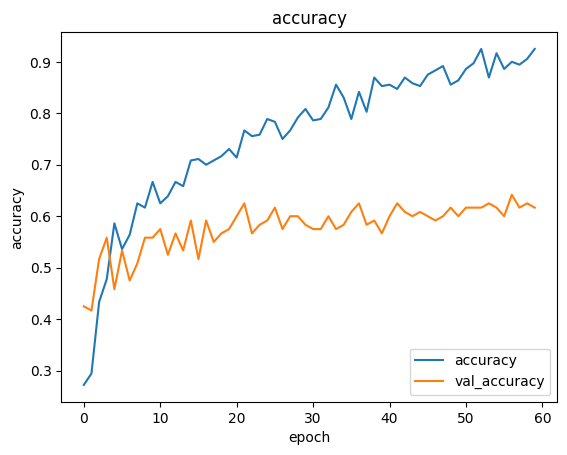

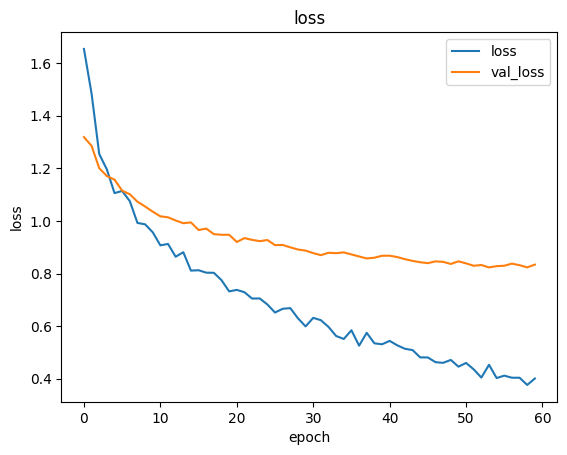

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    # 精度の推移をプロット
    plt.plot(history.history['accuracy'],"-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"-",label="val_accuracy")
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の推移をプロット
    plt.plot(history.history['loss'],"-",label="loss",)
    plt.plot(history.history['val_loss'],"-",label="val_loss")
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()

# 損失と精度をグラフに出力
plot_acc_loss(history)

In [45]:
from sklearn.metrics import accuracy_score

# テストデータに対する予測を取得
predictions = model.predict(validation_data)
predicted_labels = np.argmax(predictions, axis=1)

# 各ラベルごとのAccuracyを計算
unique_labels = np.unique(validation_labels)
label_accuracies = {}

for label in unique_labels:
    # 現在のラベルに対応するインデックスを取得
    indices = np.where(validation_labels == label)

    # 予測されたラベルと実際のラベルを抽出
    label_preds = predicted_labels[indices]
    actual_labels = validation_labels[indices]

    # Accuracyを計算
    accuracy = accuracy_score(actual_labels, label_preds)
    label_accuracies[label] = accuracy

# 各ラベルのAccuracyを表示
for label, acc in label_accuracies.items():
    print(f"Label {label} Accuracy: {acc:.4f}")


4/4 [==============================] - 0s 4ms/step
Label 0 Accuracy: 0.6000
Label 1 Accuracy: 0.6000
Label 2 Accuracy: 0.3667
Label 3 Accuracy: 0.9000
